<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import X and y

In [ ]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
os.chdir('/content/drive/MyDrive/Thesis')

In [ ]:
y = pd.read_csv('Arousal_frames_emodb.csv')

In [ ]:
y = y.iloc[:,[1]]

In [ ]:
#y_8000_rows = y[0:14000]
y = y[0:14276]

In [ ]:
#y_arr = y_8000_rows.to_numpy()
y_arr = y.to_numpy()

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [ ]:
chunk = 100
#i=0
X=[]
import pandas as pd
for i, df in enumerate(pd.read_csv('X_matrix.csv',chunksize = chunk)):
    X.append(df)
   # i=i+1
    print('Processed {i}/140 chunks'.format(i=i))
   



Processed 1/110 chunks
Processed 2/110 chunks
Processed 3/110 chunks
Processed 4/110 chunks
Processed 5/110 chunks
Processed 6/110 chunks
Processed 7/110 chunks
Processed 8/110 chunks
Processed 9/110 chunks
Processed 10/110 chunks
Processed 11/110 chunks
Processed 12/110 chunks
Processed 13/110 chunks
Processed 14/110 chunks
Processed 15/110 chunks
Processed 16/110 chunks
Processed 17/110 chunks
Processed 18/110 chunks
Processed 19/110 chunks
Processed 20/110 chunks
Processed 21/110 chunks
Processed 22/110 chunks
Processed 23/110 chunks
Processed 24/110 chunks
Processed 25/110 chunks
Processed 26/110 chunks
Processed 27/110 chunks
Processed 28/110 chunks
Processed 29/110 chunks
Processed 30/110 chunks
Processed 31/110 chunks
Processed 32/110 chunks
Processed 33/110 chunks
Processed 34/110 chunks
Processed 35/110 chunks
Processed 36/110 chunks
Processed 37/110 chunks
Processed 38/110 chunks
Processed 39/110 chunks
Processed 40/110 chunks
Processed 41/110 chunks
Processed 42/110 chunks
P

In [ ]:
X = pd.concat(X)

In [ ]:
del X [X.columns[0]]

In [ ]:
X_arr = X.to_numpy()

In [ ]:
X_arr = np.reshape(X_arr,(14276,224,224))

In [ ]:
X_arr.shape

(14000, 224, 224)

In [ ]:
del X

Adding new dimension for CNN

In [ ]:
X_ = X_arr[:,:,np.newaxis]

In [ ]:
X_ = np.swapaxes(X_,2,1)

In [ ]:
X_.shape

(14000, 1, 224, 224)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_,y_arr,test_size=0.2,random_state=42)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2,random_state=42)

Clear variables that are not in use anymore

In [ ]:
del X_
del X_arr

In [ ]:
del y_arr

Converting X to appropriate Datatype...

In [ ]:
X_tensor_train = torch.from_numpy(X_train)
X_tensor_test = torch.from_numpy(X_test)
#X_tensor_val = torch.from_numpy(X_val)

y_tensor_train = torch.from_numpy(y_train)
y_tensor_test = torch.from_numpy(y_test)
#y_tensor_val = torch.from_numpy(y_val)

In [ ]:
del X_train, X_test, y_train, y_test#, X_val, y_val

In [ ]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
#X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)
#y_tensor_val = y_tensor_val.type(torch.LongTensor)

Pytorch needs the true labels to be in the range N-1. Thus, substract 1 one from each label.

In [ ]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1
#y_tensor_val = y_tensor_val-1

Loading remaining data...

In [ ]:
y_frames = y[14276:].to_numpy()

In [ ]:
# loading frames samples
chunk = 100
frames = []
for i, df in enumerate(pd.read_csv('X_frames.csv'),chunksize=chunk):
  frames.append(df)
  


In [ ]:
frames = pd.concat(frames)

In [ ]:
frames = frames.to_numpy()

In [ ]:
frames = frames.reshape(frames,(7348,224,224))

In [ ]:
frames = frames[:,:,np.newaxis]

In [ ]:
frames = np.swapaxes(frames,2,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(frames, y_frames, test_size = 0.2, random_state=42)

In [ ]:
del frames, y_frames

In [ ]:
X_tensor_train_fr = torch.from_numpy(X_train)
X_tensor_test_fr = torch.from_numpy(X_test)

y_tensor_train_fr = torch.from_numpy(y_train)
y_tensor_test_fr = torch.from_numpy(y_test)

In [ ]:
del X_train, X_test, y_train, y_test

In [ ]:
X_tensor_train_fr = torch.tensor(X_tensor_train_fr,dtype = torch.float32)
X_tensor_test_fr = torch.tensor(X_tensor_test_fr,dtype = torch.float32)

y_tensor_train_fr = y_tensor_train_fr.type(torch.LongTensor)
y_tensor_test_fr = y_tensor_test_fr.type(torch.LongTensor)

In [ ]:
y_tensor_train_fr = y_tensor_train_fr -1
y_tensor_test_fr = y_tensor_test_fr -1

In [ ]:
X_tensor_train = torch.cat(X_tensor_train,X_tensor_train_fr)
X_tensor_test = torch.cat(X_tensor_test,X_tensor_test_fr)

y_tensor_train = torch.cat(y_tensor_train,y_tensor_train_fr)
y_tensor_test = torch.cat(y_tensor_test,y_tensor_test_fr)

In [ ]:
print('training shape X is {}, test shape X is{}'.format(X_tensor_train.shape,X_tensor_test.shape))
#print('validation shape X is {}'.format(X_tensor_val.shape))

training shape X is torch.Size([11200, 1, 224, 224]), test shape X istorch.Size([2800, 1, 224, 224])


Setup custom dataset class

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [ ]:
dataset_train = SimpleDataset(X_tensor_train,y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

#dataset_val = SimpleDataset(X_tensor_val,y_tensor_val)
#dataloader_val = DataLoader(dataset_val,batch_size=32)

dataset_test = SimpleDataset(X_tensor_test,y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


Setting up the CNN.

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout(0.5)
        #self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(774400, 10)#,128)
        #self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = F.relu(x)
        #x = self.dropout2(x)
        #x = self.fc2(x)
        return x
#removed second layer

In [ ]:
SalienceNet = CNN()

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def analysis(net, loss_fn, dataloader_train,dataloader_test,
          epoch=100, learning_rate=0.001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    train_loss = []
   
    train_total_loss = []
    train_accuracy = []
    for i in range(epoch):
        total,correct = 0,0
        
        net.to(device)   
        net.train()
        for data, label in dataloader_train:
            data, label = data.to(device), label.to(device)
        #make prediction
            output = net(data.float())

            _, y_pred_train = torch.max(output,1) # get predicted train label

            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            loss = criterion(output,torch.max(label.long(), 1)[0])

            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient udpate.

            total += label.size(0)
            correct += (y_pred_train == torch.max(label,1)[0]).sum().item()
            
            train_loss.append(loss.item())
            print('currently processing epoch {}'.format(i))
            #print('batch accuracy of {}'.format(100*(correct/total)))
            
            #if (i + 1) % (epoch // 5) == 0:
             #print(f'iteration {i + 1}/{epoch} | loss: {loss.item():.3f}')
    

    train_accuracy.append(correct/total)

    net.eval()
    test_loss = []
    test_total,test_correct = 0,0
    test_acc = []
    for data, labels in dataloader_test:
        print('testing...')

        data, labels = data.to(device), labels.to(device)
        outputs = net(data.float())

        _, y_pred_test = torch.max(outputs,1) # get predicted label for test

        test_l = criterion(outputs,torch.max(labels.long(), 1)[0])
        test_loss.append(test_l.item())

        test_total += labels.size(0)
        test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

    print('test acc is {}'.format(test_acc))

    return train_loss,test_loss,train_accuracy,test_acc 


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [ ]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,test_loss,train_acc,test_acc=analysis(net=SalienceNet,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_test=dataloader_test,epoch=10)




currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently proc

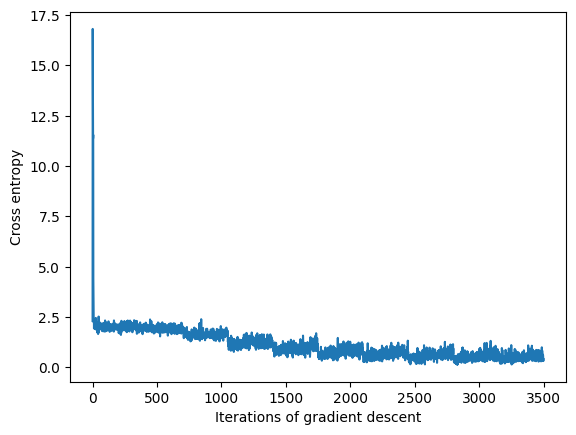

In [ ]:
plt.plot(train_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.show()

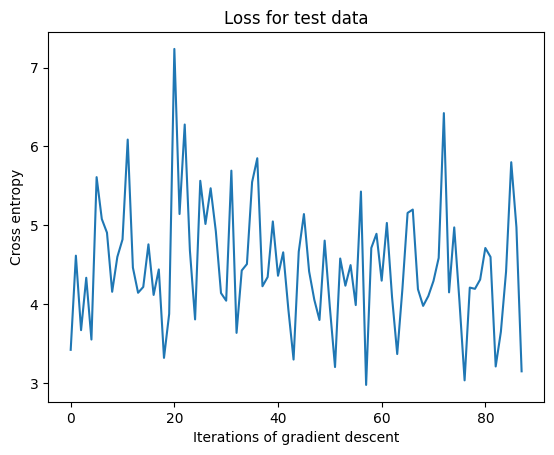

In [ ]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.title('Loss for test data')
plt.show()

In [ ]:
print('training accuracy is {}'.format(train_acc))
print('test accuracy is {}'.format(test_acc))

training accuracy is [0.8294642857142858]
test accuracy is [0.20857142857142857]
